In [1]:
%reload_ext autoreload
%autoreload 2

from Scratch import metadata_loader
import numpy as np
from tqdm import tqdm

DEVICE = "ibm_sherbrooke"
LOGICAL = str(0)
XBASIS = True
ROUNDS = 100

state = "X" if XBASIS else "Z"
state += LOGICAL
print(f"state = {state}")


# Load the metadata
md = metadata_loader(True, True)
md = md[md["job_status"] == "JobStatus.DONE"]
md = md[md["code"] == "RepetitionCodeCircuit"]
md = md[md["descr"] == 'subset RepCodes']
md = md.dropna(subset=["rounds"])
md = md[md["meas_level"] == 1]
md['rounds'] = md['rounds'].astype(int)
md['distance'] = md['distance'].astype(int)

md = md[md["backend_name"] == DEVICE]
md = md[md["logical"] == LOGICAL]
md = md[md["xbasis"] == XBASIS]
md = md[md["rounds"] == ROUNDS]

md = md[md['notebook_name']=='Sherbrooke_RepCodes_jobs']

# md = md[0:1]
print("shape:", md.shape)
md[:2]


state = X0
shape: (40, 18)


,creation_date,notebook_name,backend_name,job_id,tags,meas_level,shots,num_qubits,job_status,execution_date,code,distance,rounds,logical,descr,resets,xbasis,path_info
5315,2024-03-23 17:56:21.062000+01:00,Sherbrooke_RepCodes_jobs,ibm_sherbrooke,cqzgkd5ktf3g00883v1g,"[Subset 52, 100 rounds, 0 log, xbasis=True]",1.0,768.0,NaN,JobStatus.DONE,2024-03-23 18:34:16.754492+01:00,RepetitionCodeCircuit,52,100,0,subset RepCodes,NaN,True,"{'mean_gate_error': 0.008345314216382, 'min_ga..."
5314,2024-03-23 17:56:05.176000+01:00,Sherbrooke_RepCodes_jobs,ibm_sherbrooke,cqzgk95dvs8g008j6ep0,"[Subset 52, 100 rounds, 0 log, xbasis=True]",1.0,768.0,NaN,JobStatus.DONE,2024-03-23 18:33:46.104916+01:00,RepetitionCodeCircuit,52,100,0,subset RepCodes,NaN,True,"{'mean_gate_error': 0.008345314216382, 'min_ga..."


In [2]:
from result_saver import SaverProvider

provider = SaverProvider()
md_loc = 0

job_id = md.iloc[md_loc]["job_id"]
job = provider.retrieve_job(job_id) 

execution_date = job.result().date
memory = job.result().get_memory()

print(f"Execution date: {execution_date}")

Execution date: 2024-03-23 18:34:16.754492+01:00


In [3]:
from soft_info import inv_qubit_mapping, get_repcode_IQ_map

_RESETS = False
SOFT_MUL = 0.5
T = md.iloc[md_loc]["rounds"]
d = md.iloc[md_loc]["distance"]

shots = md.iloc[md_loc]["shots"]
# Get the layout of the last job (same as previous)
layout_des = job.deserialize_layout(job.initial_layouts()[0]) # only 1 layout
link_qubits = list(layout_des['link_qubit'].values())
code_qubits = list(layout_des['code_qubit'].values())

# Get the pSoft and countMat matrices
big_layout = link_qubits + code_qubits
inverted_q_map = inv_qubit_mapping(get_repcode_IQ_map(big_layout, synd_rounds=T))

In [4]:
from Scratch import load_calibration_memory

all_memories_PS, _, msmt_err_dict = load_calibration_memory(provider, tobecalib_job=job_id, post_process=True, double_msmt=True)

Specified job execution date: 2024-03-23 18:34:16.754492+01:00
Found jobs for backend ibm_sherbrooke with closest execution date 2024-03-23 17:35:19.496822+00:00.


# IQ Convertor

In [5]:
from typing import Tuple
import numpy as np

from tqdm import tqdm

from soft_info import fit_gmm_0_calib, process_gmm_data, get_gmm_RepCodeData, plot_RepCode_gmm
from sklearn.preprocessing import StandardScaler


qubit_list = [27, 44, 61, 69, 74, 80, 103, 107]
qubit_list = [27, 44]
qubit_list = [27, 80, 72, 14]

def GMMIQConvertor(IQ_data: np.ndarray, 
                   all_memories: dict, 
                   inverted_q_map: dict, 
                   plot: bool = False) -> Tuple[Tuple[np.ndarray], dict]:
    """
    This function takes in IQ data and converts it to a GMM representation. It uses the calibration data from the memories to fit the GMMs.
    The function returns the GMM representations of the IQ data and the GMMs used to convert the data.

    Parameters:
       - IQ_data (np.ndarray): The IQ data to be converted to GMM representation.
       - all_memories (dict): The calibration data from the memories.
       - inverted_q_map (dict): The mapping from physical qubits to the IQ data.
       - plot (bool): Whether to plot the GMM representations or not.

    Returns:
       - Tuple[Tuple[np.ndarray], dict]: (countMat, pSoft, estim0matrix, estim1matrix, estim2matrix), gmm_dict
                                    The GMM representations of the IQ data and the GMMs used to convert the data.
                                    
    """
    countMat = np.zeros_like(IQ_data, dtype=int)
    pSoft, estim0matrix, estim1matrix, estim2matrix = (np.zeros_like(IQ_data, dtype=float) for _ in range(4))

    gmm_dict = {}
    # for phys_idx, col_indices in inverted_q_map.items():
    for phys_idx, col_indices in tqdm(inverted_q_map.items()):
        # if phys_idx not in qubit_list:
        #     continue
        if len(col_indices) > 5:
            continue
        IQ_data_cols = IQ_data[:, col_indices].flatten()
        mmr_0 = all_memories[phys_idx]['mmr_0']

        IQ_data_proc, mmr_0_proc, _ = process_gmm_data(IQ_data_cols, mmr_0)
        print(f"len IQ_data_proc: {len(IQ_data_proc)}")
        gmm_0 = fit_gmm_0_calib(mmr_0_proc)
        gmm = get_gmm_RepCodeData(IQ_data_proc, gmm_0)
        gmm_dict[phys_idx] = gmm
        plot = plot_RepCode_gmm(IQ_data_proc, gmm) if plot else None

        probas = gmm.predict_proba(IQ_data_proc) + 1e-30

        # reorder to make sure 0, 1, 2 corresponds to states
        probas = reorder_gmm_components(gmm, probas, phys_idx)

        classifications = np.argmax(probas, axis=1)
        countMat[:, col_indices] = classifications.reshape(-1, len(col_indices))

        pSoft[:, col_indices] = (1 / (1 + np.max(probas[:, :2], axis=1) / np.min(probas[:, :2], axis=1))).reshape(-1, len(col_indices))   
        # pSoft[:, col_indices] = (1 / (1 + np.max(probas, axis=1) / np.min(probas, axis=1))).reshape(-1, len(col_indices))   

        estim0matrix[:, col_indices] = probas[:, 0].reshape(-1, len(col_indices))  
        estim1matrix[:, col_indices] = probas[:, 1].reshape(-1, len(col_indices)) if probas.shape[1] > 1 else None
        estim2matrix[:, col_indices] = probas[:, 2].reshape(-1, len(col_indices)) if probas.shape[1] > 2 else None
        

    return (countMat, pSoft, estim0matrix, estim1matrix, estim2matrix), gmm_dict

def reorder_gmm_components(gmm, probas, qubit):
    # Ensure Probas 0 corresponds to the component with the smallest x-value in its mean
    smallest_x_index = np.argmin(gmm.means_[:, 0])
    if smallest_x_index != 0:
        print(f"Reordering qubit {qubit}: Component with smallest x-value is not at index 0, but at index {smallest_x_index}.")
        new_order = np.arange(gmm.n_components)
        new_order[0], new_order[smallest_x_index] = new_order[smallest_x_index], new_order[0]
        probas = probas[:, new_order]

    # Check and reorder to ensure that for the two other modes the one with the lowest weight is 2
    if gmm.n_components > 2:
        if gmm.weights_[1] > gmm.weights_[2]:
            print(f"Reordering qubit {qubit}: Component at index 2 does not have the lowest weight.")
            probas[:, [1, 2]] = probas[:, [2, 1]]
    
    return probas
            

  0%|          | 0/103 [00:00<?, ?it/s]

len IQ_data_proc: 768


 50%|█████     | 52/103 [00:00<00:00, 168.36it/s]

len IQ_data_proc: 768
len IQ_data_proc: 768
len IQ_data_proc: 768
len IQ_data_proc: 768
len IQ_data_proc: 768
len IQ_data_proc: 768
len IQ_data_proc: 768
len IQ_data_proc: 768
len IQ_data_proc: 768
len IQ_data_proc: 768
len IQ_data_proc: 768
len IQ_data_proc: 768
len IQ_data_proc: 768
len IQ_data_proc: 768
len IQ_data_proc: 768
len IQ_data_proc: 768


 67%|██████▋   | 69/103 [00:02<00:01, 24.95it/s] 

len IQ_data_proc: 768
len IQ_data_proc: 768
len IQ_data_proc: 768
len IQ_data_proc: 768
12:58:59 Warning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.. IN FILE: /Users/mha/My_Drive/Desktop/Studium/Physik/MSc/Semester_3/IBM/IBM_GIT/Soft-Info/src/soft_info/Probabilities/gmm_fitting.py, LINE: 116
len IQ_data_proc: 768
len IQ_data_proc: 768
len IQ_data_proc: 768
len IQ_data_proc: 768


 75%|███████▍  | 77/103 [00:02<00:01, 22.66it/s]

len IQ_data_proc: 768
len IQ_data_proc: 768
len IQ_data_proc: 768
len IQ_data_proc: 768


 80%|███████▉  | 82/103 [00:03<00:01, 20.83it/s]

len IQ_data_proc: 768
len IQ_data_proc: 768
len IQ_data_proc: 768
len IQ_data_proc: 768
len IQ_data_proc: 768
len IQ_data_proc: 768


 86%|████████▋ | 89/103 [00:03<00:00, 18.33it/s]

len IQ_data_proc: 768
len IQ_data_proc: 768
len IQ_data_proc: 768
len IQ_data_proc: 768


 89%|████████▉ | 92/103 [00:03<00:00, 18.31it/s]

len IQ_data_proc: 768
len IQ_data_proc: 768
len IQ_data_proc: 768
len IQ_data_proc: 768
len IQ_data_proc: 768


 92%|█████████▏| 95/103 [00:04<00:00, 17.89it/s]

len IQ_data_proc: 768
len IQ_data_proc: 768
len IQ_data_proc: 768


 97%|█████████▋| 100/103 [00:04<00:00, 15.22it/s]

len IQ_data_proc: 768
len IQ_data_proc: 768
len IQ_data_proc: 768


100%|██████████| 103/103 [00:04<00:00, 22.36it/s]


len IQ_data_proc: 768
len IQ_data_proc: 768


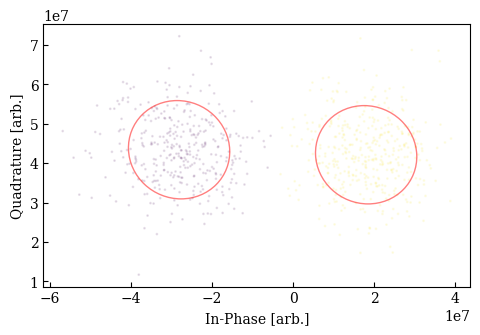

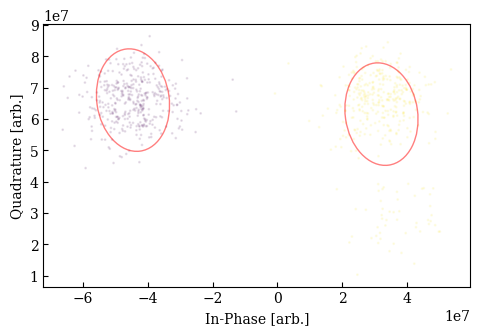

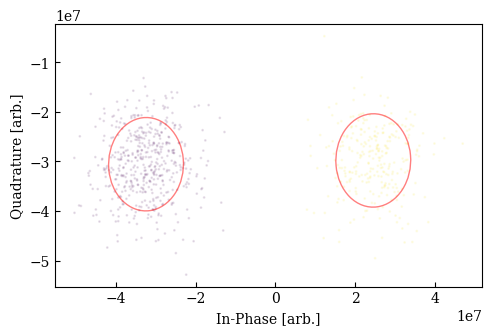

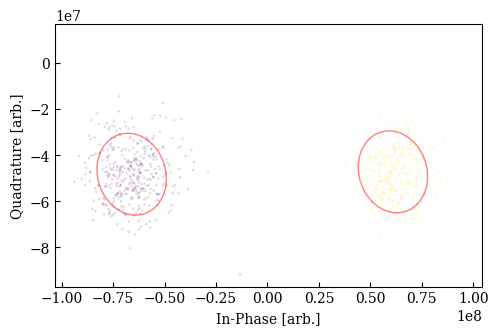

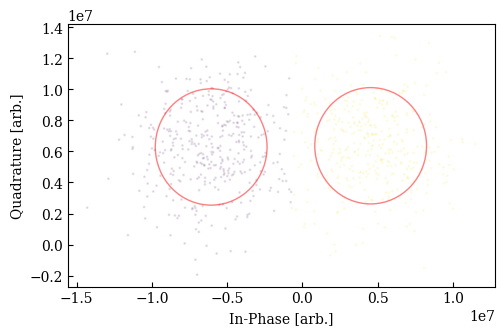

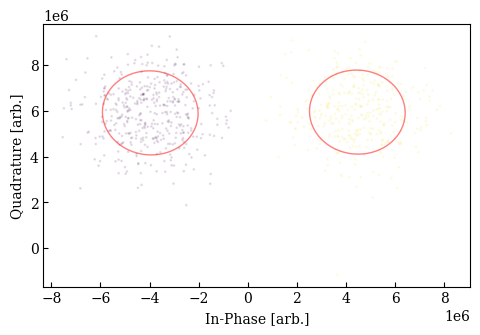

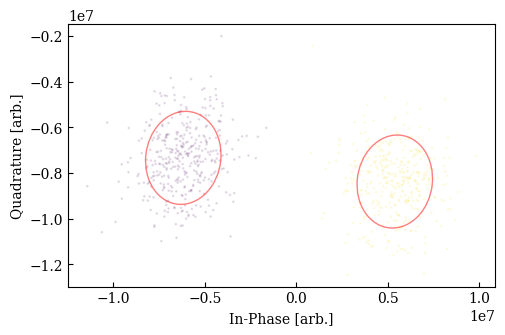

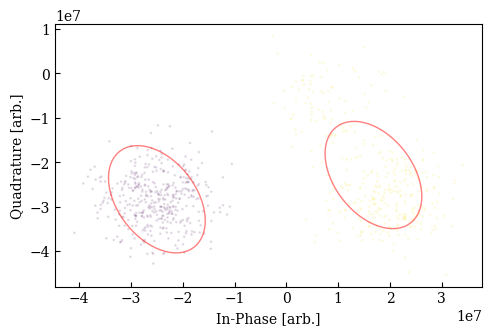

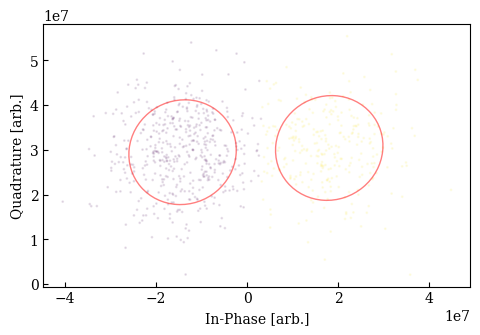

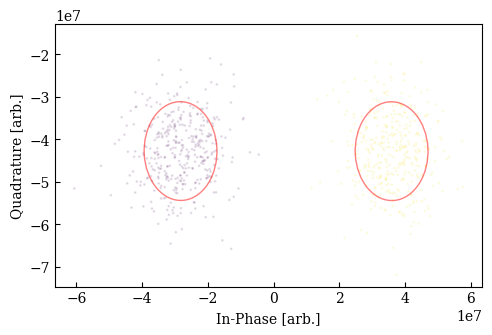

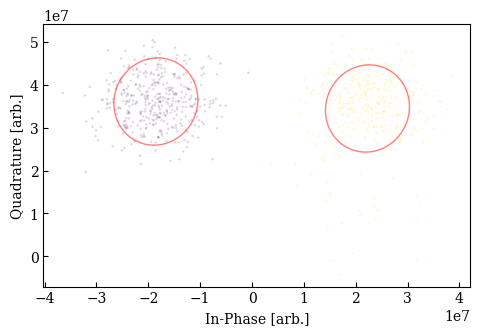

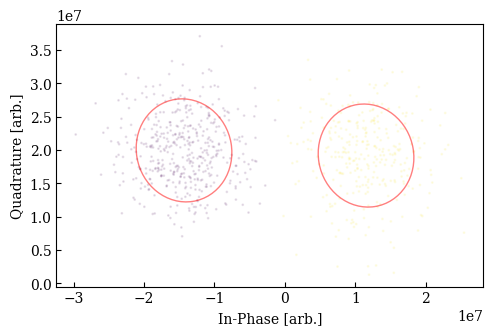

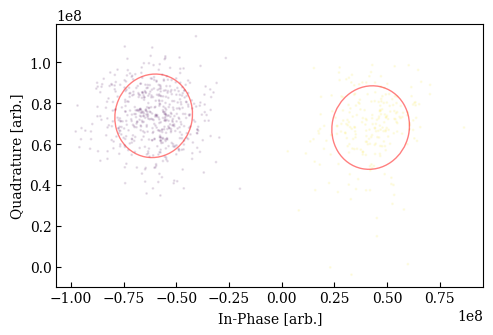

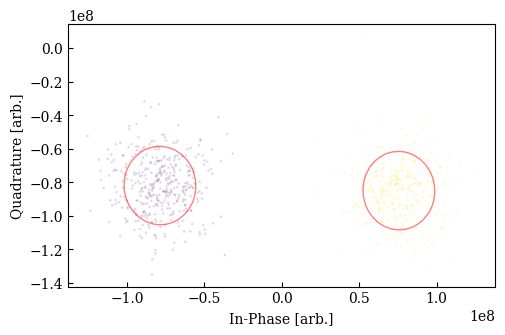

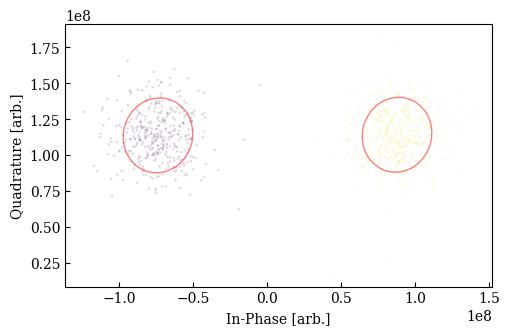

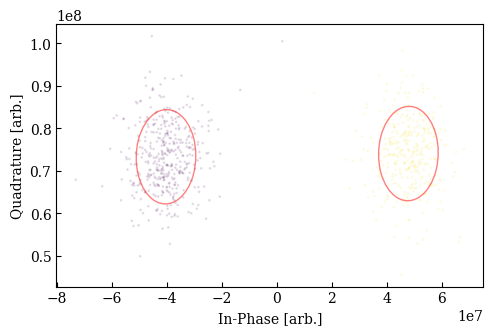

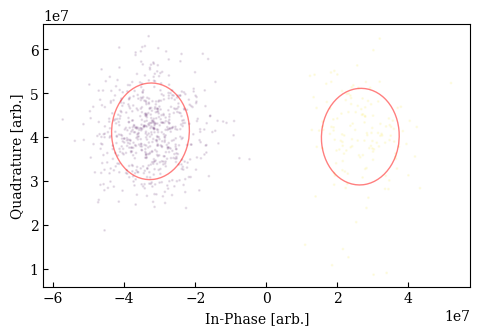

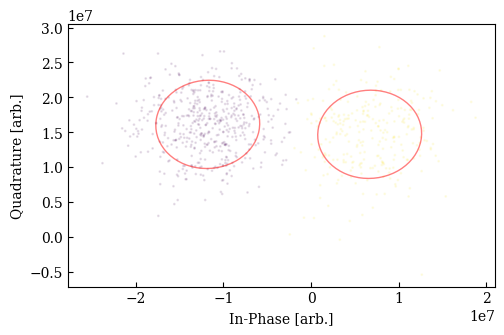

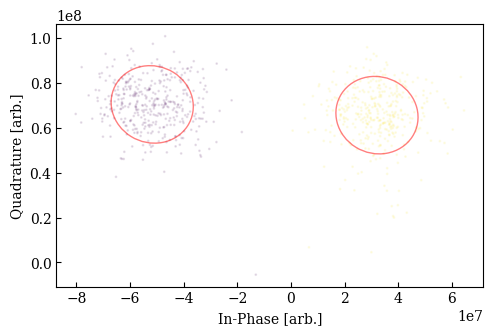

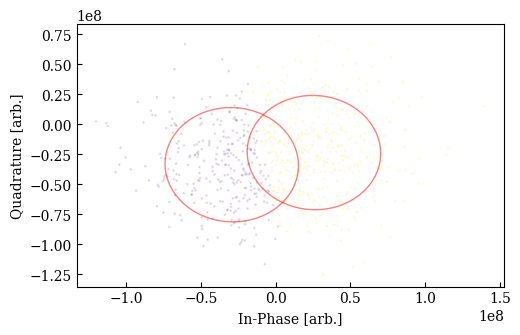

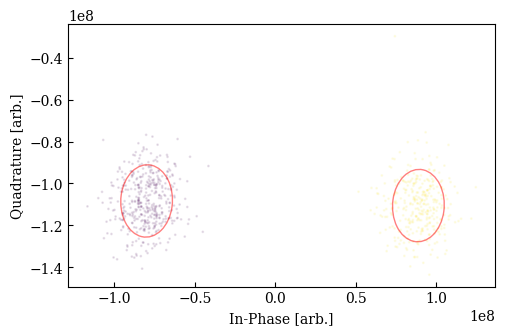

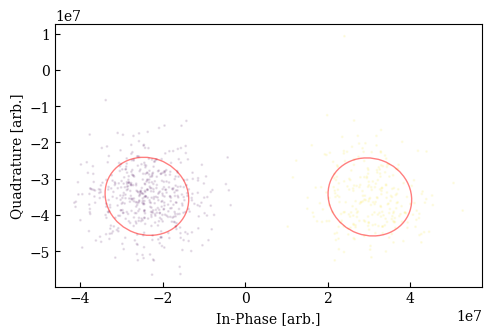

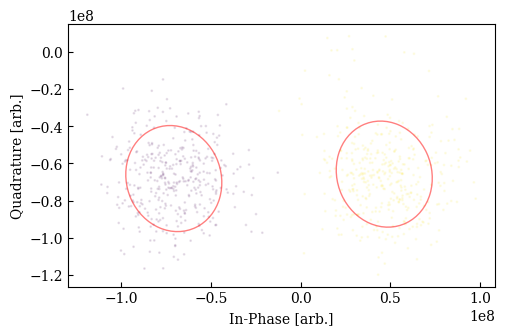

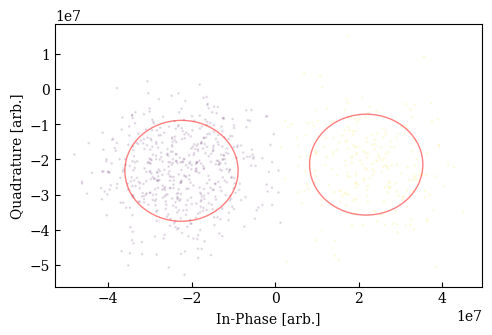

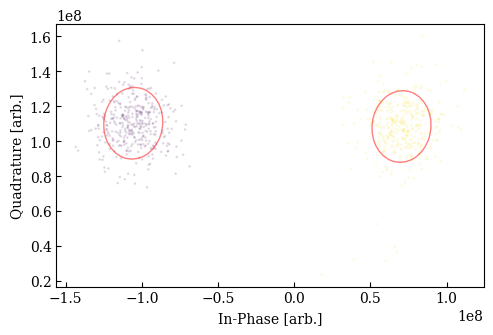

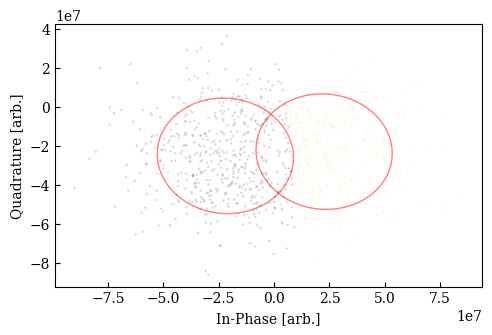

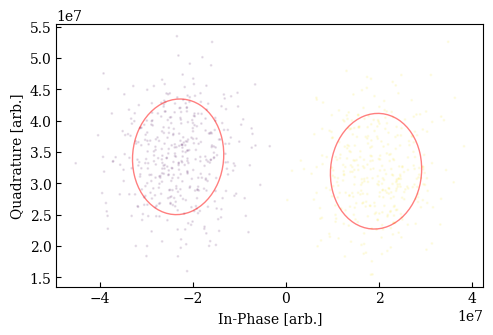

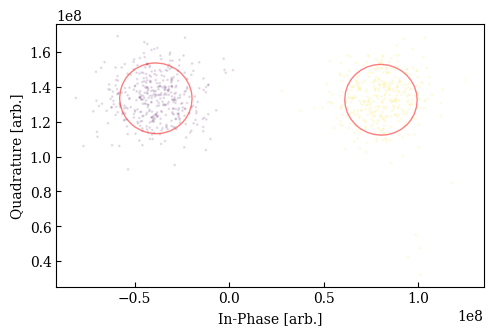

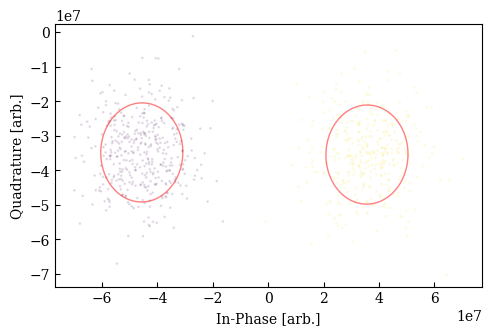

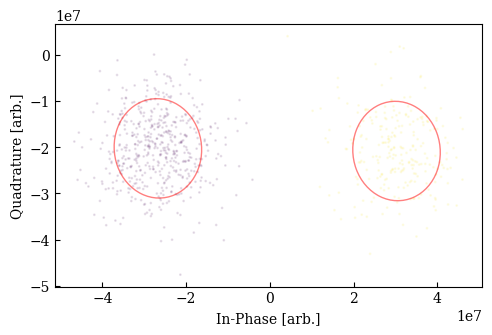

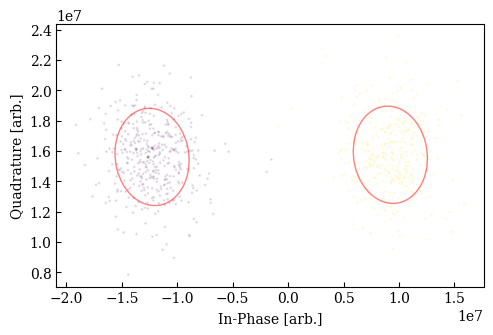

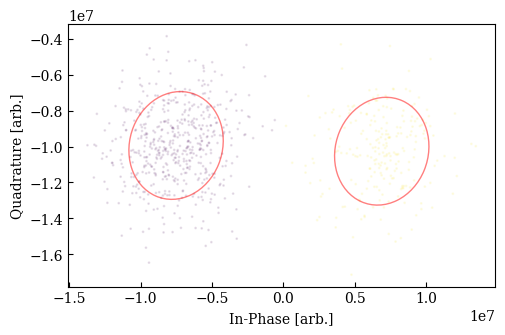

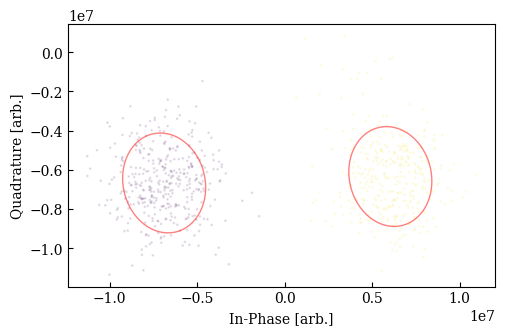

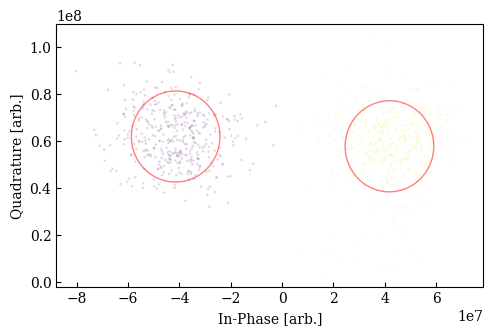

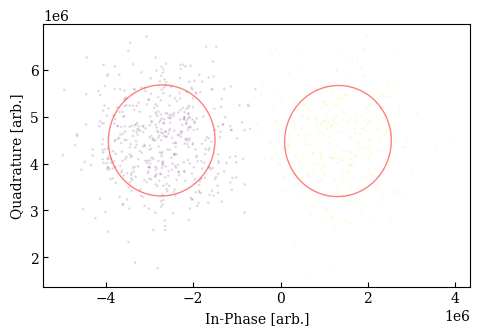

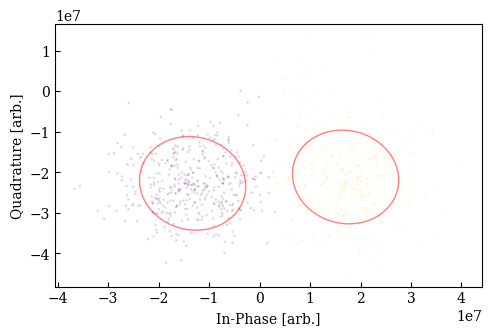

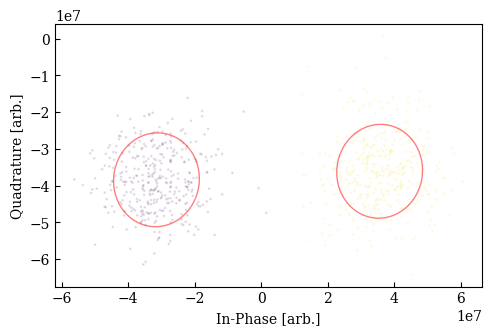

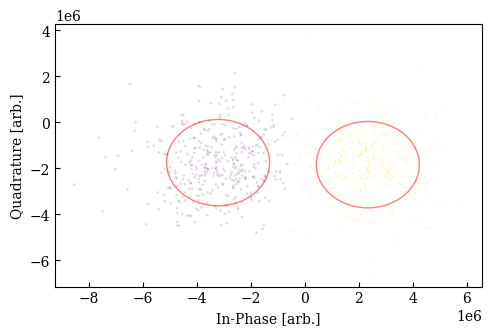

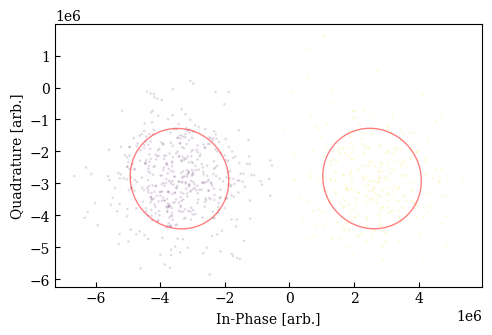

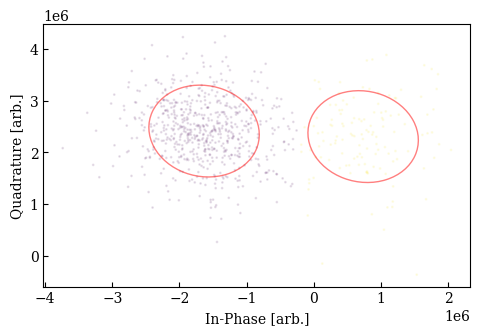

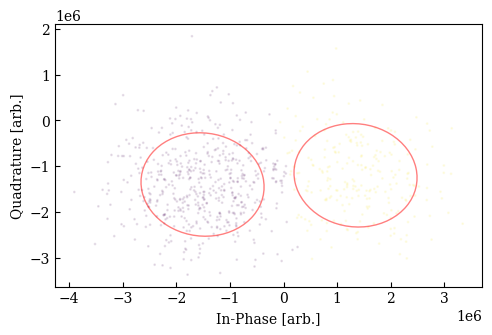

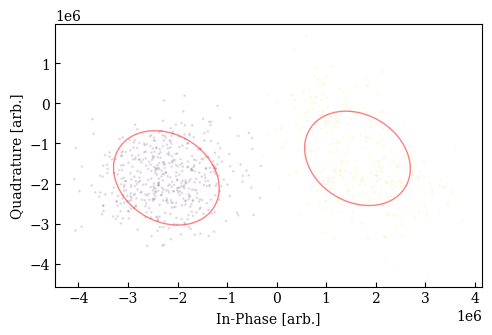

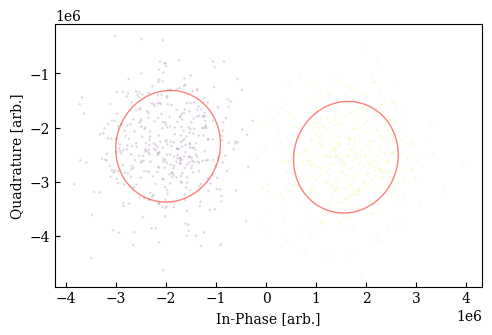

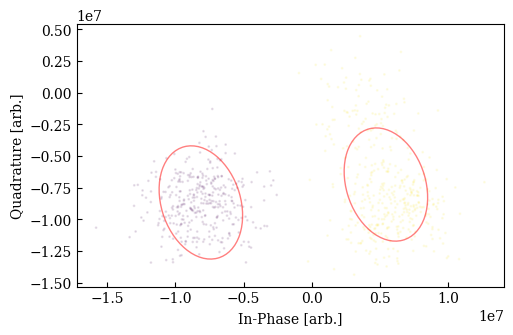

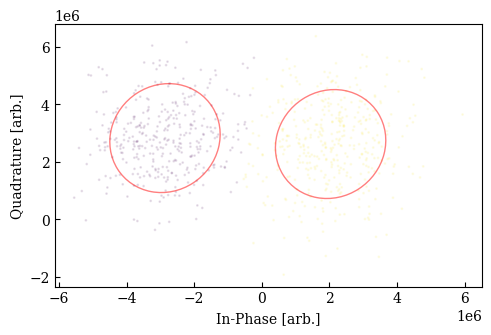

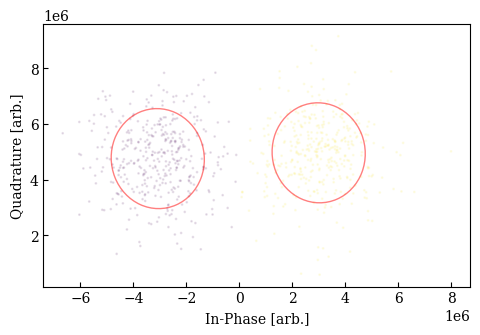

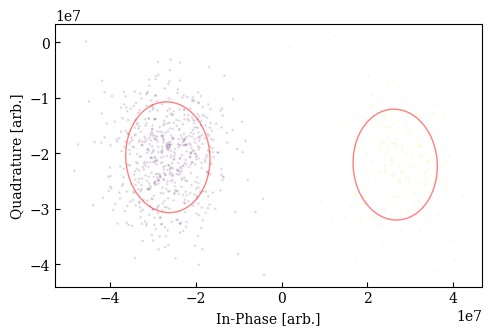

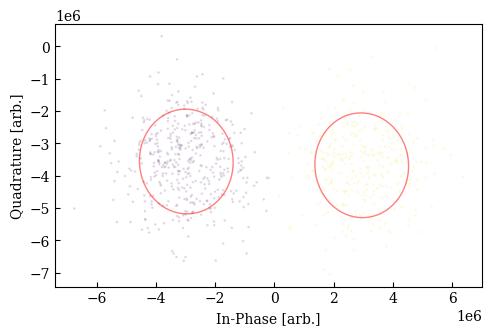

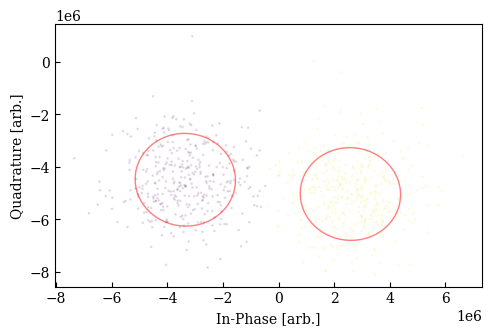

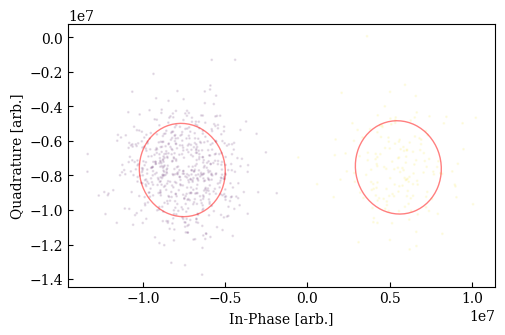

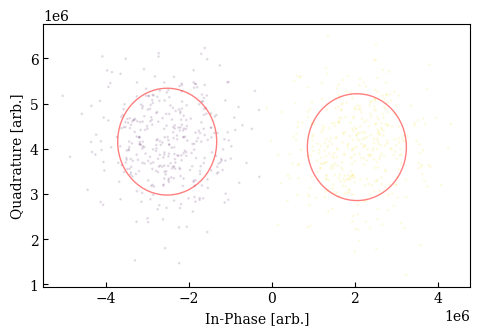

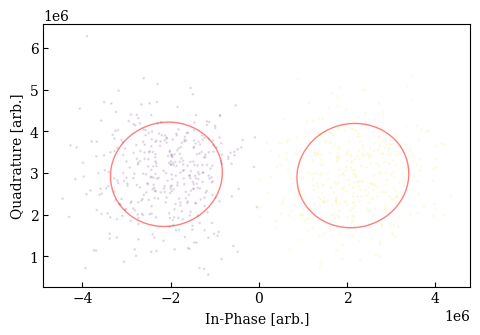

In [6]:
(countMat, pSoft, estim0matrix, estim1matrix, estim2matrix), gmm_dict = GMMIQConvertor(memory, all_memories_PS, inverted_q_map, plot=True)


Qubit 99
Shape countMat: (768, 100)
Unique countMat: (array([0]), array([76800]))
mean pSoft: 0.0


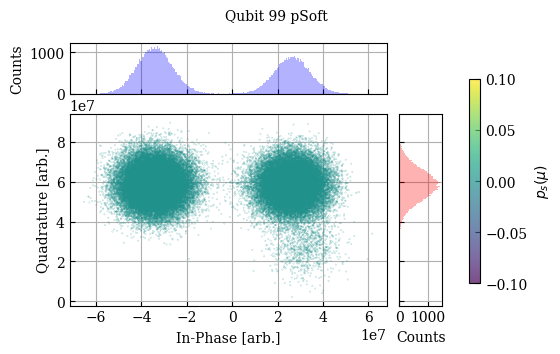

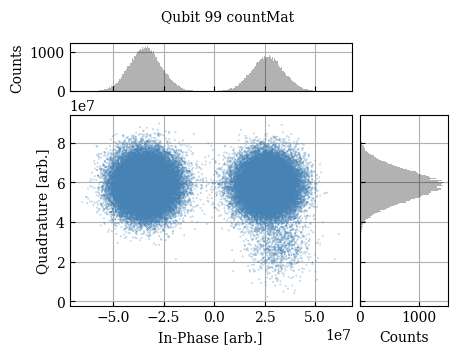


Qubit 91
Shape countMat: (768, 100)
Unique countMat: (array([0]), array([76800]))
mean pSoft: 0.0


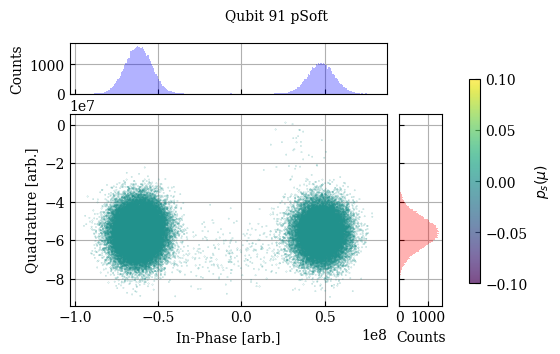

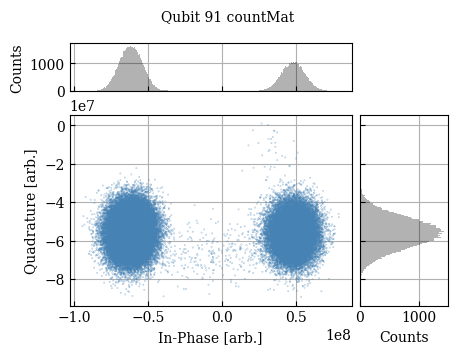


Qubit 80
Shape countMat: (768, 100)
Unique countMat: (array([0, 1, 2]), array([42592,  1030, 33178]))
mean pSoft: 0.004980565676549328


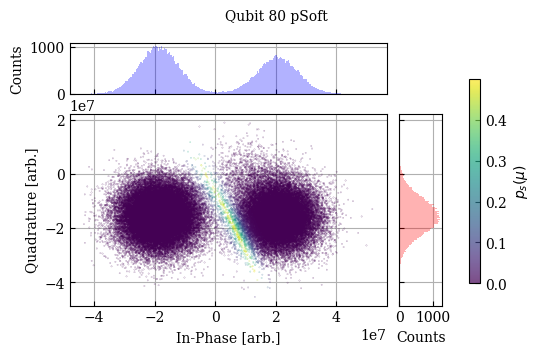

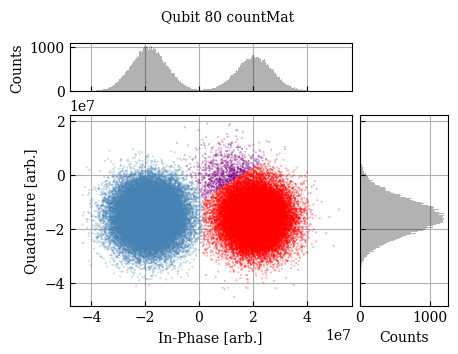


Qubit 72
Shape countMat: (768, 100)
Unique countMat: (array([0, 1]), array([45417, 31383]))
mean pSoft: 0.03701874650165251


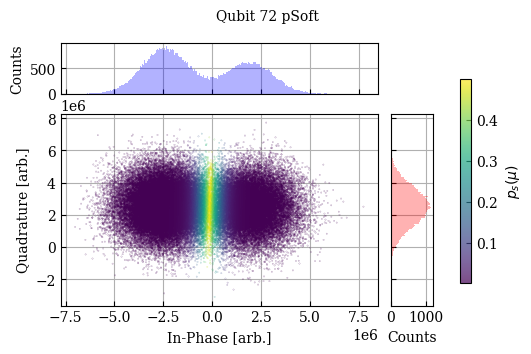

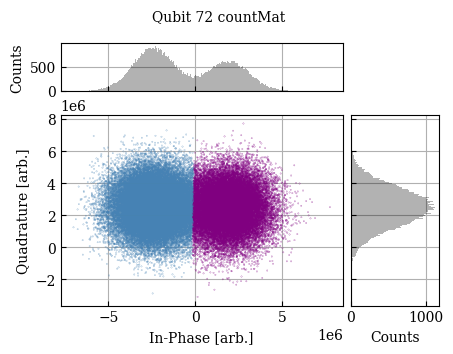


Qubit 61
Shape countMat: (768, 100)
Unique countMat: (array([0]), array([76800]))
mean pSoft: 0.0


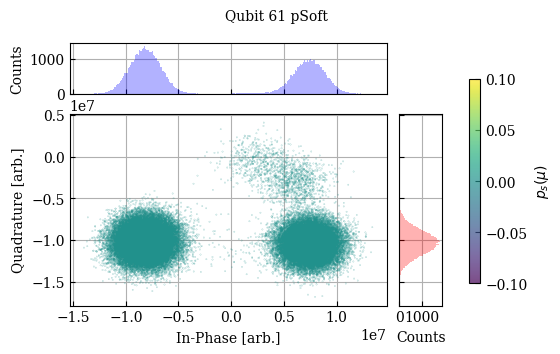

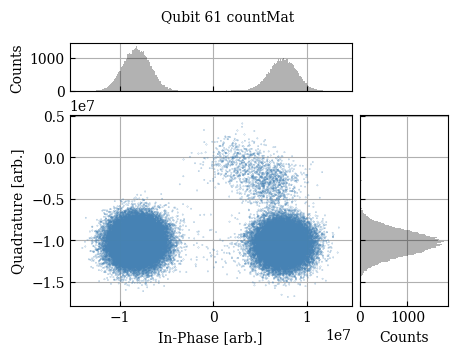


Qubit 59
Shape countMat: (768, 100)
Unique countMat: (array([0]), array([76800]))
mean pSoft: 0.0


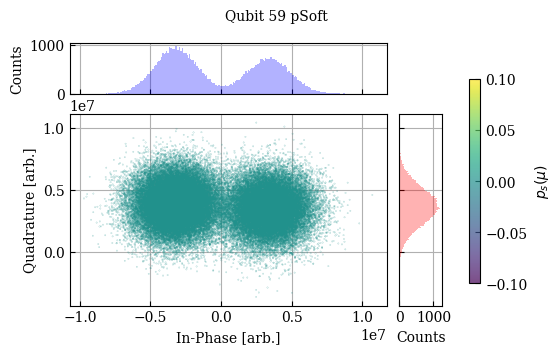

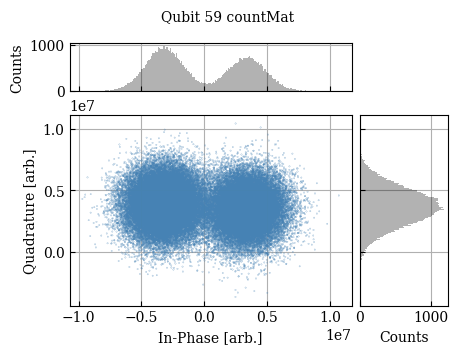

In [26]:
from soft_info import plot_IQ_data_pSoft_cmap, plot_IQ_data_with_countMat

# for qubit in qubit_list:
for idx, qubit in enumerate(inverted_q_map.keys()):
    if idx > 5:
        break
    cols = inverted_q_map[qubit]
    print(f"\nQubit {qubit}")
    print(f"Shape countMat: {countMat[:, cols].shape}")
    print(f"Unique countMat: {np.unique(countMat[:, cols], return_counts=True)}")
    print(f"mean pSoft: {np.mean(pSoft[:, cols])}")

    plot_IQ_data_pSoft_cmap(memory[:, cols], pSoft[:, cols], title=f"Qubit {qubit} pSoft")
    plot_IQ_data_with_countMat(memory[:, cols], countMat[:, cols], title=f"Qubit {qubit} countMat")
